In [1]:
# !pip3 install tensorflow_datasets
import tensorflow as tf
import numpy as np

In [2]:
import tensorflow_datasets as tfds
(train_ds, test_ds), info = tfds.load('shapes3d', split=['train[:15%]', 'train[15%:20%]'], with_info=True)

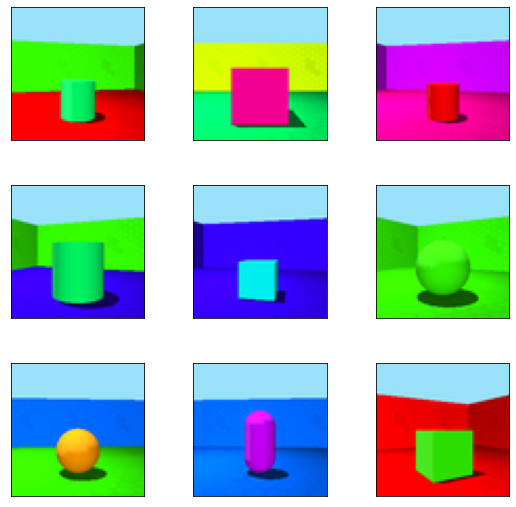

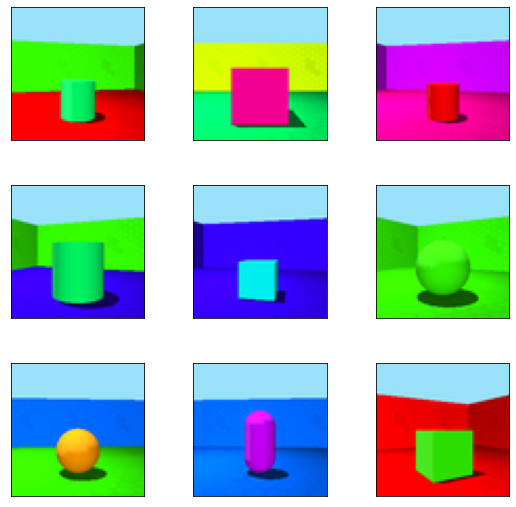

In [4]:
fig = tfds.show_examples(train_ds, info)
fig

In [5]:
# rtrieving image arrays
train_dataset, test_dataset = [], []
for i in train_ds:
    train_dataset.append(i['image'])
for i in test_ds:
    test_dataset.append(i['image'])    

In [6]:
with tf.device('/device:CPU:0'): 
    # converting to tensor slices and batching
    train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
    test_dataset = tf.data.Dataset.from_tensor_slices(test_dataset)

    batch_size = 64
    train_ds = train_dataset.batch(batch_size)
    test_ds = test_dataset.batch(batch_size)

In [7]:
shape = (64, 64, 3)
latent_dim = 2

In [8]:
class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        # specify coding size
        self.latent_dim = latent_dim
        # build encoder - "reducing dimension of images" through encoding
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(64, 64, 3)), # input image size: 
                tf.keras.layers.Rescaling(scale=1/255),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu'), # convolutional layer with 32 "feature maps"
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'), # convolutional layer with 64 "feature maps"
                tf.keras.layers.Flatten(),
                # latent dim for extracting mus and the other for sigmas
                tf.keras.layers.Dense(latent_dim + latent_dim),
                
            ]
        )
        # build decoder - expands dimensions through decoding
        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=16*16*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(16, 16, 32)), # mirrors fully connected layer of encoder
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'), # mirrors convolutional later of encoder
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'), # mirrors convolutional later of encoder
                # No activation for the same reason as the encoder, since we want an image and not a non-linear transformation
                # of the features
                tf.keras.layers.Conv2DTranspose(
                    filters=3, kernel_size=3, strides=1, padding='same'), 
                
            ]
        )

    @tf.function 
    def sample(self, eps=None):
        '''
        epsilon is applied during hte reparameterization trick.
        '''
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        '''
        Encode input using encoder network
        '''
        # split encoder output into vector for means and another for variances
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar): 
        '''
        Used for dealing with the problem of a choppy latent representation.
        Essentially, drawning samples z from the latent representation is the same
        as drawing from ε x log(σ) + μ (i.e.: z = ε x σ + μ), but the latter is
        continuous making backpropagation efficient, meaningful and stable
        '''
        eps = tf.random.normal(shape=mean.shape)
        # z = ε x σ + μ with exponential to reduce exploding gradients
        return eps * tf.exp(logvar *.5) + mean

    def decode(self, z, apply_sigmoid=False):
        '''
        Decode sample from latent vectors using decoder network, outputs logits to which sigmoid cross entropy
        is applied when building loss function
        '''
        logits = self.decoder(z)
#         print(logits.shape)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [17]:
optimizer = tf.keras.optimizers.Adam(1e-4)
import scipy as scipy

def log_normal_pdf(sample, mean, logvar, raxis=1):
    '''
    get the lognormal probability for reparameterized sample through mean and logvar
    '''
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi)
        , axis=raxis)


def compute_loss(model, x):
    '''
    - Maximing the ELBO means minimizing the loss.
    - According to tf api documentation, in practice, we instead try to maximize single sample probabilities.
    - In other words, by reducing the loss function, we are optimizing the similarity of distributions of encoder
    and decoder networkds
    '''
    # get mean and logvar from encoder outputs
    mean, logvar = model.encode(x) 
    # isntead of smapling from mean and logvar, we reparameterize for the reason explained above
    z = model.reparameterize(mean, logvar) 
    
    # apply decoder to z as the reparameterized version of the sample
    x_logit = model.decode(z) 
    # differences in distributions
    x = tf.image.convert_image_dtype(x, tf.float32)
    # used sigmoid cross entropy to comapre labels with x_logits
    cross_ent =tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    
    # conditional distribution of input to encoder x given  
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3]) 
  
    # latent distribution prior sampled from the above
    logpz = log_normal_pdf(z, 0., 0.) 

    # encoder's distribution, takes in sample z which are the reparameterized samples 
    logqz_x = log_normal_pdf(z, mean, logvar)

    # minimizing (the magnitude of) this loss means minizing the difference between probability distributions 
    return -tf.reduce_mean(logpx_z + logpz - logqz_x) 

# decorator that makes processing efficient by representing training in network form 
@tf.function
def train_step(model, x, optimizer, Print):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    # custom training steps
    with tf.GradientTape() as tape: 
        # compites loss given input x to encoder
        loss = compute_loss(model, x)
    # defines where gradients are applied (trainable variables = weights)
    gradients = tape.gradient(loss, model.trainable_variables)
    # the actual back propagation step
    optimizer.apply_gradients(zip(gradients, model.trainable_variables)) 

In [18]:
epochs = 50
# set the dimensionality of the latent space to a plane for visualization later
num_examples_to_generate = 16
batch_size =128

# keeping the random vector constant for generation (prediction) so it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [19]:
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z) 
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='brg')
        plt.axis('off')
#     plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [20]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_ds.take(1): 
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 50, Test set ELBO: -4515.66259765625, time elapse for current epoch: 19.26674795150757


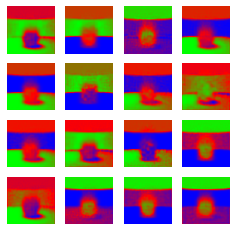

In [22]:
import matplotlib.pyplot as plt
import time
import numpy as np
tf.config.run_functions_eagerly(True)
from IPython.display import clear_output


generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
    # training
    start_time = time.time()
    for train_x in train_ds:
        train_step(model, train_x, optimizer, Print=True)
    end_time = time.time()

    # Testing loss
    loss = tf.keras.metrics.Mean()
    for test_x in test_ds:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
    generate_and_save_images(model, epoch, test_sample)

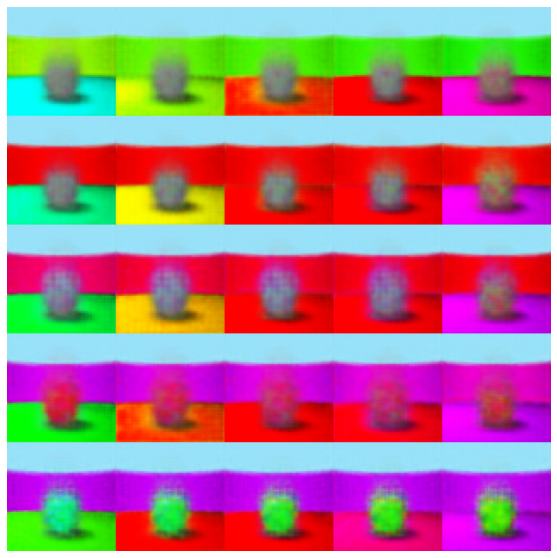

In [25]:
# !pip install --upgrade tensorflow-probability
import tensorflow_probability as tfp

def plot_latent_images(model, n, digit_size=28):
    """Plots n x n digit images decoded from the latent space."""
    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width, 3))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
            digit = tf.reshape(x_decoded[0], (digit_size, digit_size, 3))
            image[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='brg')
    plt.axis('Off')
    plt.show()

plot_latent_images(model, 5, 64)